# Introduction


1. I'm calculating the TD twice -- I need to optimize this
2. Need to get the hyperparameters from the paper

### Without PER

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from agent import Agent
from keras.utils import to_categorical
import time
%matplotlib inline


def to_grayscale(img):
    return np.mean(img, axis=2).astype(np.uint8)

def downsample(img):
    return img[::2, ::2]

def preprocess(img):
    return to_grayscale(downsample(img))

def transform_reward(reward):
    return np.sign(reward)


#Environment
env = gym.make('Breakout-v0')
state = env.reset()
state = preprocess(state)
input_dim = state.shape
output_dim = env.action_space.n

#Agent
lr,gamma = 0.001, 0.99
agent = Agent(input_dim, output_dim, lr, gamma)
agent.C = 1000  #update the target network every K timestesp
agent.epsilon = 0.5
agent.tau = 0.1
decay_factor = 0.99
epsilon_min = 0.01
learning_start = 500


#Train
EPISODES = 2
scores = []
t1 = time.time()
state = []
for e in range(1,EPISODES+1):
    frame = env.reset()
    frame = preprocess(frame)
    reward_sum = 0
    done = False
    step = 0
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward_sum += reward
        agent.remember(state, action, reward, next_state, done)

        if agent.buffer.num_memories() > learning_start:
            agent.replay()                       #update the behavior model
            agent.soft_update_target_network()   #update the target model every C timesteps

        #iterate
        step += 1
        if done:
            break

    #Learn & print results
    scores.append(step)
    agent.epsilon = max(agent.epsilon*decay_factor,epsilon_min)
    if e % 1 == 0:
        t2 = time.time()
        print '(episode, score, Tmin) = ' + str((e,step, (t2-t1)/60.0 ))
plt.plot(scores)

ValueError: cannot reshape array of size 100800 into shape (1,210)

In [5]:
state = []
state = [frame, frame, frame]

In [15]:
state = np.zeros((4,frame.shape[0],frame.shape[1]))

In [12]:
state[0] = frame

In [16]:
agent.model.predict(state)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., ...

In [18]:
state.shape

(4, 105, 80)

### With PER

(episode, score, Tmin) = (10, 59, 0.44720991849899294)
(episode, score, Tmin) = (20, 81, 0.9235019008318583)
(episode, score, Tmin) = (30, 65, 1.3403635501861573)
(episode, score, Tmin) = (40, 11, 1.5113670865694682)
(episode, score, Tmin) = (50, 58, 1.675524385770162)
(episode, score, Tmin) = (60, 64, 1.8318503181139627)
(episode, score, Tmin) = (70, 28, 1.9415942668914794)
(episode, score, Tmin) = (80, 36, 2.07981375058492)
(episode, score, Tmin) = (90, 20, 2.1775878349939983)
(episode, score, Tmin) = (100, 13, 2.2636984666188558)


(0, 200)

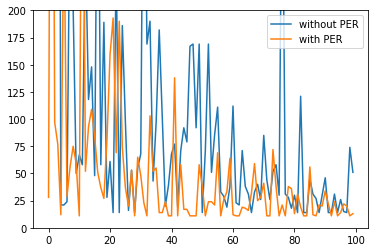

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#from agent_vanilla import Agent
from agent import Agent
from keras.utils import to_categorical
from blind_cliffwalk import Env
%matplotlib inline


#Environment
num_states = 12
env = Env(num_states)
num_states = env.observation_space
num_actions = env.action_space

#Agent
lr,gamma = 0.001, 0.99
agent = Agent(num_states, num_actions, lr, gamma)
agent.C = 1000  #update the target network every K timestesp
agent.epsilon = 0.5
agent.tau = 0.1
decay_factor = 0.99
epsilon_min = 0.01
learning_start = 500


#Train
EPISODES = 100
scores1 = []
t1 = time.time()
for e in range(1,EPISODES+1):
    state = env.reset()
    state = to_categorical(state,num_states)
    reward_sum = 0
    done = False
    step = 0
    while not done:

        # env.render()
        state = np.reshape(state, [1, num_states])  #reshape for keras
        action = agent.act(state)
        next_state, reward, done, _ = env.step(state[0], action)
        next_state = to_categorical(next_state,num_states)
        reward_sum += reward
        agent.remember(state[0], action, reward, next_state, done)
        state = next_state
        #print state, action

        if agent.buffer.num_memories() > learning_start:
            agent.replay(prioritised = True)                       #update the behavior model
            agent.soft_update_target_network()   #update the target model every C timesteps

        #iterate
        step += 1
        if done:
            break

    #Learn & print results
    scores1.append(step)
    agent.epsilon = max(agent.epsilon*decay_factor,epsilon_min)
    if e % 10 == 0:
        t2 = time.time()
        print '(episode, score, Tmin) = ' + str((e,step, (t2-t1)/60.0))
plt.plot(scores)
plt.plot(scores1)
plt.legend(['without PER', 'with PER'])
plt.ylim([0,200])

In [ ]:
def solve(prior, num_episodes):
    
    #Environment
    num_states = 15
    env = Env(num_states)
    num_states = env.observation_space
    num_actions = env.action_space

    #Agent
    lr,gamma = 0.001, 0.99
    agent = Agent(num_states, num_actions, lr, gamma)
    agent.C = 1000  #update the target network every K timestesp
    agent.epsilon = 0.5
    agent.tau = 0.1
    decay_factor = 0.99
    epsilon_min = 0.01
    learning_start = 500


    #Train
    EPISODES = num_episodes
    scores = []
    t1 = time.time()
    for e in range(1,EPISODES+1):
        state = env.reset()
        state = to_categorical(state,num_states)
        reward_sum = 0
        done = False
        step = 0
        while not done:

            # env.render()
            state = np.reshape(state, [1, num_states])  #reshape for keras
            action = agent.act(state)
            next_state, reward, done, _ = env.step(state[0], action)
            next_state = to_categorical(next_state,num_states)
            reward_sum += reward
            agent.remember(state[0], action, reward, next_state, done)
            state = next_state
            #print state, action

            if agent.buffer.num_memories() > learning_start:
                agent.replay(prioritised = prior)                       #update the behavior model
                agent.soft_update_target_network()   #update the target model every C timesteps

            #iterate
            step += 1
            if done:
                break

        #Learn & print results
        scores.append(step)
        agent.epsilon = max(agent.epsilon*decay_factor,epsilon_min)
        
    return np.array(scores)


prior = False
num_episodes = 100
scores = np.zeros(num_episodes)
for trial in range(20):
    temp = solve(prior, num_episodes)
    scores += temp
plt.plot(scores / (1.*num_episodes))

prior = True
scores1 = np.zeros(num_episodes)
for trial in range(20):
    temp = solve(prior, num_episodes)
    scores1 += temp
plt.plot(scores1 / (1.*num_episodes))